In [82]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

# Replicating Blom & Peletier
The goal of this notebook is to replicate the numerical solution in Blom & Peletier's paper (*A continuum model of lipid bilayers*). 

Basic setup: A 1D domain with two population densities of lipids, $u(x)$ and $v(x)$, whose tails point in the positive and negative directions, respectively. These represent the tail distributions, so the overall tail distribution is
\begin{equation*}
\text{tails}(x) = u(x) + v(x)
\end{equation*}

The lipids are $\varepsilon$ long, so the head distribution is therefore
\begin{align*}
\text{heads} &= u(x + \varepsilon) + v(x - \varepsilon) \\
&= \tau_{-\varepsilon} u + \tau_\varepsilon v
\end{align*}

We seek distributions $u, v$ that minimise the free energy
\begin{equation*}
F(u, v) = \int \eta(u) + \eta(v) + \alpha (1 - u - v)\kappa * (u + v) - \zeta(c_0)\,dx
\end{equation*}
where
\begin{equation*}
    \eta(s) = \begin{cases} 
        \log s & \text{if } s \ge 0 \\
        \infty & \text{otherwise}
    \end{cases}
\end{equation*}
is the entropy, $\alpha$ and $\kappa$ represent the interaction of heads and tails by making tails ($u + v$) unfriendly to heads and water $(1 - u - v)$. $0 < c_0 < \frac{1}{4}$ is the background concentration (concentration at infinity) and $\zeta(c_0)$ is a constant for integrability (it doesn't really matter).

The interaction kernel is given by 
\begin{equation*}
\kappa(s) = \frac{1}{2}e^{-|s|}.
\end{equation*}

### Conservation of mass
We also have conservation of mass
\begin{equation}
\int u + v - 2c_0 \,dx = m
\end{equation}

### Density limits
and a condition making sure we don't exceed a density of $1$:
\begin{equation*}
1 - u - \tau_{-\varepsilon} u - v - \tau_\varepsilon v \ge 0
\end{equation*}


## Euler-Lagrange equations
The Euler-Lagrange equations for minimising $F(u, v)$ (including the bonus term) subject to the conservation of mass constraint are:

\begin{align*}
\log{u} - 2\alpha \kappa*(u + v) &= \lambda - \mu - \tau_\varepsilon \mu \\
\log{v} - 2\alpha \kappa*(u + v) &= \lambda - \mu - \tau_{-\varepsilon} \mu
\end{align*}

where $\lambda$ is a Lagrange multiplier, and $\mu \in L^\infty(\mathbb{R})$ is also a Lagrange multiplier which is nonzero only where the saturation condition holds exactly.

With an infinite domain, $\lambda$ can be found by looking at infinity where $\mu = 0$ and $u, v = c_0$, giving $u = v$ and hence $\lambda = \log c_0 - 4\alpha c_0$.



### Constrained gradient flow solution

We can set this up as a gradient flow problem on $[-L, L]$:

\begin{align*}
u_t &= -\log u + 2\alpha\kappa*(u + v) + \lambda - \mu - \tau_\varepsilon \mu \\
v_t &= -\log v + 2\alpha\kappa*(u + v) + \lambda - \mu - \tau_{-\varepsilon} \mu
\end{align*}

where $\mu = K\max\{0, \mu + \tau_{-\varepsilon}u + v + \tau_\varepsilon{v} - 1\}$. This equation comes from instead of having the original inequality constraint, we instead add a penalty for exceeding the density of $\frac{K}{2} \int(u + \tau_{-\varepsilon}u + v + \tau_\varepsilon v - 1)_+^2$ to $F(u, v)$.


We cannot yet solve these numerically as the Lagrange multiplier $\lambda$ is unknown. But it makes sense we have an unknown still, we haven't taken into account conservation of mass:

We have the additional constraint that $\int u + v - 2c_0\,dx = m$, or differentiating,
\begin{equation*}
  \int_{-L}^L u_t + v_t\,dx = 0.
\end{equation*}

We can see that 
\begin{equation*}
  \int_{-L}^L u_t + v_t\,dx = \int_{-L}^L -\log u - \log v + 2\lambda + 
  4\alpha\kappa*(u + v) - 2\mu - \tau_\varepsilon \mu - \tau_{-\varepsilon} \mu\,dx = 0
\end{equation*}
but $\lambda$ is not a function of $x$, so
\begin{equation*}
  \lambda = \frac{1}{4L}\int_{-L}^L \log u + \log v - 
  4\alpha\kappa*(u + v) + 2\mu + \tau_\varepsilon \mu +\tau_{-\varepsilon} \mu\,dx
\end{equation*}
The right hand side of the ODE system is now fully-specified, and can be solved numerically.

In [83]:
# Define domain and other parameters

# Domain
L = 30
dx = 0.1
x = np.arange(-L, L + dx, dx)
N = x.shape[0]

# Parameters
eps = 3 # Needs to be a multiple of dx
K = 0.001
alpha = 4

beta = 1
c_0 = 0.0625

n_eps = int(np.round(eps/dx)) # number of grid points to shift

# Set up shifting functions - again using periodic boundary conditions
def tau_e_plus(y):
    return np.roll(y, -n_eps)

def tau_e_minus(y):
    return np.roll(y, +n_eps)

### Interaction kernel

We're assuming periodic boundaries for now (for convenience), `convolve1d` can handle this with the `wrap` option.

If we change the boundary condition to a different type, we'll need to modify how we do the interaction

Text(0.5, 1.0, 'Interaction kernel $\\kappa$')

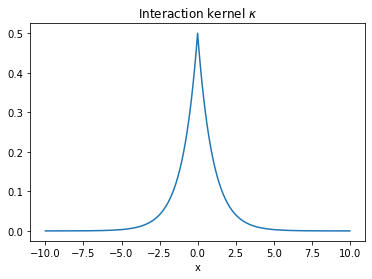

In [84]:
from scipy.ndimage import convolve1d

# Interaction kernel
x_ker = np.arange(-10, 10+dx, dx)
kappa = 0.5*np.exp(-np.abs(x_ker))

def convolve_with_kappa(y):
    return dx*convolve1d(y, kappa, mode='wrap')

plt.plot(x_ker, kappa)
plt.xlabel('x')
plt.title('Interaction kernel $\kappa$')

### Defining the integro-differential equation system



In [85]:
def rhs_bp(t, y):
    u = y[0:N]
    v = y[N:]
    
    # mu = K*np.maximum(u + tau_e_minus(u) + v + tau_e_plus(v) - 1, 0)
    
    mu = u + tau_e_minus(u) + v + tau_e_plus(v) - 1


    kuv = convolve_with_kappa(u + v)
    
    # calculate derivatives with lambda absent (c.f. equations above)
    ut_i = -np.log(u) + 2*alpha*kuv - K/mu**2 - K/(tau_e_plus(mu)**2)
    vt_i = -np.log(v) + 2*alpha*kuv - K/mu**2 - K/(tau_e_minus(mu)**2)
    
    # Total change in ut and vt should be zero (this is the conservation of mass)
    lam = -(np.sum(ut_i) + np.sum(vt_i))/(2*N)
    
    # Actual derivatives need lambda added on
    return np.concatenate((ut_i + lam, vt_i + lam))


## Initial conditions

At the moment, we'll have the intial conditions be separated Gaussians. Plotting the heads/tails distributions so we don't inadvertently go above 1.

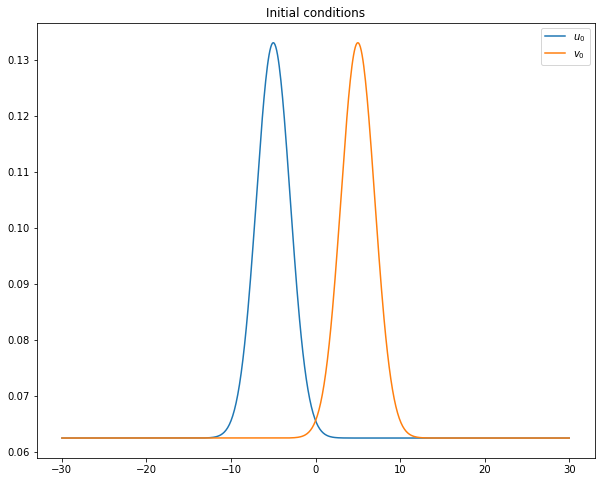

<Figure size 432x288 with 0 Axes>

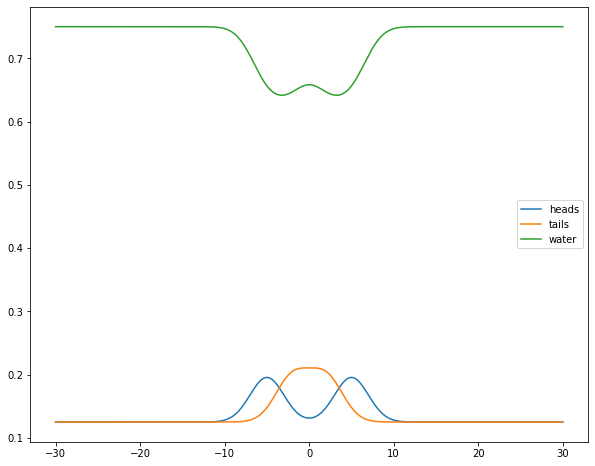

In [86]:

# Initial conditions - guassians centred on x_u and x_v
x_u = -5
x_v = 5
sigma = 2;
m = 0.5; # mass of lipids
u0 = c_0 + m/(2*sigma*np.sqrt(np.pi))*np.exp(-0.5*((x - x_u)/sigma)**2)
v0 = c_0 + m/(2*sigma*np.sqrt(np.pi))*np.exp(-0.5*((x - x_v)/sigma)**2)

def plot_solution(u, v):
    tails = u + v
    heads = tau_e_minus(u) + tau_e_plus(v)
    water = 1 - heads - tails
    plt.figure(figsize=(10, 8))
    plt.plot(x, tails, x, heads, x, water)
    plt.legend(('heads', 'tails', 'water'))

plt.figure(figsize=(10, 8))
plt.plot(x, u0, x, v0)
plt.legend(('$u_0$', '$v_0$'))
plt.title('Initial conditions')
plt.figure()
plot_solution(u0, v0)


### Solving the ODEs

Need to use an implicit solver. This could very likely be significantly sped up, but haven't done this. Need to fix issue whereby $u, v$ go negative during solve, but I don't *think* this messes up the solution. Mass conservation seems to still hold regardless.

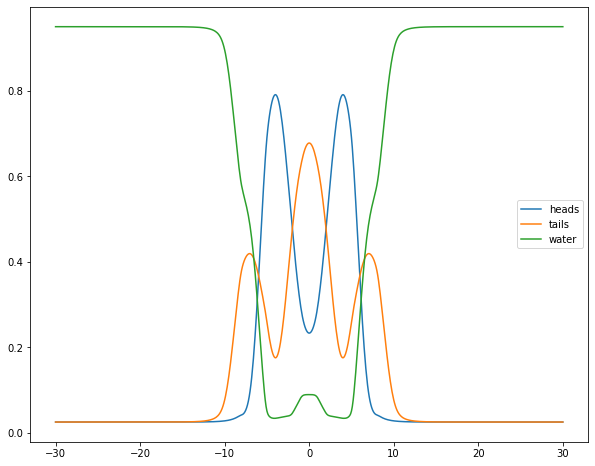

In [87]:
from scipy.integrate import solve_ivp

y0 = np.concatenate((u0, v0))
soln = solve_ivp(rhs_bp, np.arange(0, 20), y0, method='Radau')

# Plot the solution
u = soln.y[0:N, -1]
v = soln.y[N:, -1]
plot_solution(u, v)


8.219606831287894
8.219606781186528


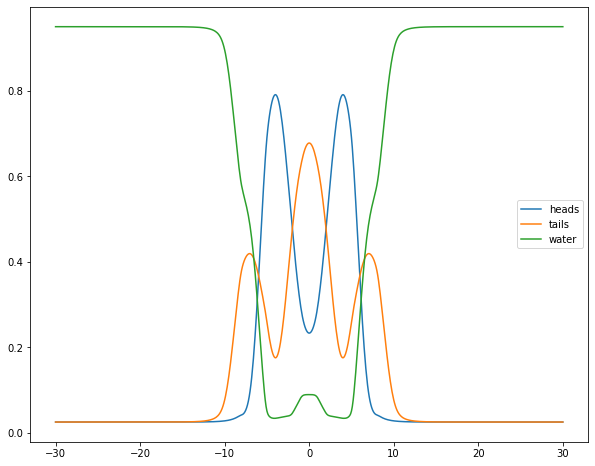

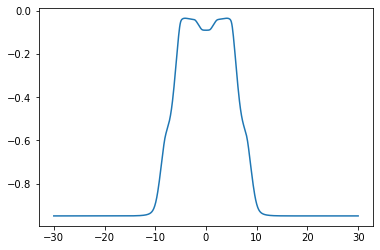

In [88]:
# Check conservation has held
print(sum(u + v)*dx)
print(sum(u0 + v0)*dx)
plot_solution_by_index(soln, -1)   

# Check non-negativity is true
mu = u + tau_e_minus(u) + v + tau_e_plus(v) - 1
plt.figure()
plt.plot(x, mu)

In [89]:
def plot_solution_by_index(soln, idx):
    u = soln.y[0:N, idx]
    v = soln.y[N:, idx]
    plot_solution(u, v)